In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Read all the words
words = open('names.txt', 'r').read().splitlines()

In [390]:
#Build mapping of characters from integers to strings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in sorted(stoi.items(), key=lambda x: x[1])}
print(itos)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [152]:
#Build the dataset

block_size = 3 #context length (how many chars we take to predict the next one)
X, Y = [], [] #inputs, and labels (traning set)

for w in words:
    #print(w)

    context = [0] * block_size
    
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)

        #print(''.join (itos[i] for i in context),'--->', itos[ix]) #this is just for visualization
        
        context = context[1:] + [ix] #crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
#Look-up table (each letter will live in a 2D space)

C = torch.randn(27, 2) #random initialization
C

In [ ]:
C[5] #this is equivalent to one_hot all the chars and putting the 5th char into the first layer of the MLP  where each Neuron linearly scales the "char" using the C matrix

In [ ]:
#Indexing context into the NN (basically the first layer but being treated as making the inputs to the actual first layer)
emb = C[X]
emb

In [ ]:
#First layer
W1 = torch.randn((emb.shape[1] * emb.shape[2], 100), requires_grad = True) #inputs from each context into 100 neurons
b1 = torch.randn((100), requires_grad = True) #biases for 100 neurons

#need emb to be 2D like W1
z1 = emb.view(-1, W1.shape[0]) @ W1 +b1
a1 = torch.tanh(z)

In [ ]:
#Second layer

W2 = torch.randn((100, 27), requires_grad = True) #100 neurons in previous layer and 27 in this layer to represent probability of each char appearing next
b2 = torch.randn((27), requires_grad = True)

logits = a1 @ W2 + b2
counts = logits.exp() #fake counts
prob = counts / counts.sum(1, keepdim=True) #probability distribution
prob.shape

In [ ]:
#Loss function: NLL
loss = -prob[torch.arange(32), Y].log().mean() #negative average of logs of current probabilities of the desired char appearing for each context
loss

In [ ]:
z1 = emb.view(-1, W1.shape[0]) @ W1 +b1
a1 = torch.tanh(z)

logits = a1 @ W2 + b2
counts = logits.exp() #fake counts
prob = counts / counts.sum(1, keepdim=True) #probability distribution
prob.shape

loss = -prob[torch.arange(32), Y].log().mean() #negative average of logs of current probabilities of the desired char appearing for each context
loss

In [285]:
#Look-up table (each letter will live in a 2D space)
C = torch.randn(27, 2) #random initialization

In [ ]:
#-------------Make it look better---------------

In [338]:
#Function to build the dataset

def build_dataset(words):
    
    block_size = 3 #context length (how many chars we take to predict the next one)
    X, Y = [], [] #inputs, and labels (traning set)
    
    for w in words:
        #print(w)
    
        context = [0] * block_size
        
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    
            #print(''.join (itos[i] for i in context),'--->', itos[ix]) #this is just for visualization
            
            context = context[1:] + [ix] #crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

#Splitting training examples into 3 sets
import random
random.shuffle(words) #shuffle the words
n1 = int(0.8*len(words)) #get the first 80%
n2 = int(0.9*len(words)) #get the first 90%

Xtr, Ytr = build_dataset(words[:n1]) #training split - first 80%
Xdev, Ydev = build_dataset(words[n1:n2]) #dev split - next 10%
Xte, Yte = build_dataset(words[n2:]) #test split - last 10%

In [339]:
Xtr.shape, Ytr.shape

(torch.Size([182325, 3]), torch.Size([182325]))

In [343]:
#Parameters
C = torch.randn(27, 10) #random initialization with chars represented in 10D
W1 = torch.randn(C.shape[1] * block_size, 200) #inputs from each context into 100 neurons
b1 = torch.randn(200) #biases for 100 neurons
W2 = torch.randn(200, 27) #100 neurons in previous layer and 27 in this layer to represent probability of each char appearing next
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

In [344]:
for p in parameters:
    p.requires_grad = True

In [345]:
#Stats to keep track of

lri = []
lossi = []
stepi = []

In [366]:
lr = 0.0016

for i in range(50000):

    ix = torch.randint(0, Xtr.shape[0], (32,)) # get 32 random indexes from the size of X
    
    #Forward pass
    emb = C[Xtr[ix]]
    z1 = emb.view(-1, W1.shape[0]) @ W1 +b1
    a1 = torch.tanh(z1)
    logits = a1 @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) #We can use this built in Torch function which is just NLL that we previously coded
    #print(loss.item())
    
    
    #Backward pass
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #learning iteration
    #lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    #track lr stats
    #lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

In [367]:
#This is the loss of the entire training split

emb = C[Xtr]
z1 = emb.view(-1, W1.shape[0]) @ W1 +b1
a1 = torch.tanh(z1)
logits = a1 @ W2 + b2
loss = F.cross_entropy(logits, Ytr) #We can use this built in Torch function which is just NLL that we previously coded
loss.item()

2.0777132511138916

In [368]:
#This is the loss of the entire dev split

emb = C[Xdev]
z1 = emb.view(-1, W1.shape[0]) @ W1 +b1
a1 = torch.tanh(z1)
logits = a1 @ W2 + b2
loss = F.cross_entropy(logits, Ydev) #We can use this built in Torch function which is just NLL that we previously coded
loss.item()

2.126005172729492

In [ ]:
#-------Stochastic Gradient Descent--------

torch.randint(0, X.shape[0], (32,)) # get 32 random indexes from the size of X

In [233]:
#-------Determining a reasonable learning rate------

lrtest = torch.linspace(0.001, 1, 1000) #1000 numbers between 0.001 and 1

#But it does not make sense to step through these lerning rates linearly
lre = torch.linspace(-3, 0, 1000) #10^-3 = 0.001 and 10^0 = 1. Now we are spaced exponentially
lrs = 10**lre
lrs

#Next, run the optimization for the number of steps in lrs (1000)
#In the optimization code, add lr = lrs[i] so the learning rate is different for every iteration and at the top of the loop put 'for i in range...'
#To keep track of the learning rate performance, make a vector lri and append the lre[i] for each iteration. Also make a vector lossi and append the loss for that iteration
#In another line type 'plt.plt(lri, lossi)
#Choose the lre at the min of the graph as your initial lr
#After iterating through the optimizer a lot and getting to a poinit where the loss is not changing substantially, do lr decay, where you make the lr smaller. Repeat this process (decaying the lr) until happy

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

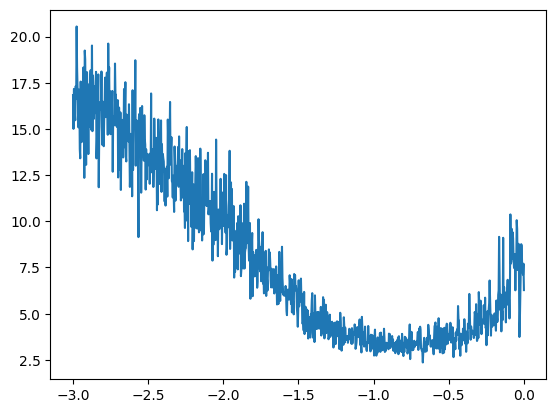

In [244]:
#Plot lri vs lossi
plt.plot(lri, lossi)

In [282]:
#To avoid overfitting we split our training examples into:
# training split (~80%), dev/validation split (~10%), test split (~10%)
# If loss of tr split ~ loss of dev split then we are underfitting. So, we need to add more parameters. First try adding more neurons, if loss does not improve significantly, make inputs more dimensions


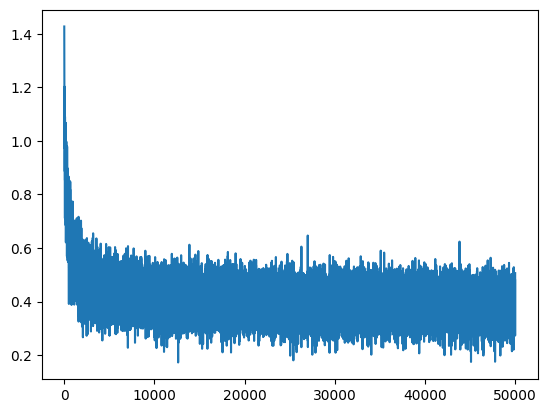

In [347]:
plt.plot(stepi, lossi)

In [405]:
#Sample from the model

for _ in range(10):
    out = []
    context = [0] * block_size

    while True:
        
        emb = C[torch.tensor([context])] #dimensions: (1, block_size)
        z1 = emb.view(-1, W1.shape[0]) @ W1 +b1
        a1 = torch.tanh(z1)
        logits = a1 @ W2 + b2
        probs = F.softmax(logits, dim = 1) #Make a probability distribution for the chance of each of the 27 chars appearing next
        ix = torch.multinomial(probs,num_samples = 1).item() #get the int corresponding to the next char
        out.append(ix) #convert to char and append
        
        context = context [1:] + [ix]
        
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

anassin.
clauriya.
aminsalei.
sasten.
jaselena.
ensloi.
een.
glo.
bryona.
alianyra.
